# One-layer neural network model for softmax regression (multiclass classification)

In this notebook, we extend logistic regression to multiclass classification using [softmax regression](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression) with.
neural network implementation with one single layer (**softmax layer**).
This is equivalent to a multinomial logistic regression model, only it is solved using neural networks (forward and backpropagation) rather than with maximum likelihood (or similar algorithms).

As example data, we again use Fisher's [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)

Basically, a neural network implementation of softmax regression looks like graph below.
There are as many units as classes in the multiclass classification problems (e.g. three classes in the *Iris* dataset: *Iris setos*, *Iris versicolor*, *Iris virginica*): each unit receives the vector of input features $\mathbf{x}$ and multiplies it by a vector of weights $\mathbf{w_u}$, specific to each unit $u$. The results are summed up together and the unit bias term $b_u$ is added. The real-valued $z_u$ variable is then activated with the *softmax* activation function to give the probability of belonging to the various classes of the problem.
In other words, each unit performs a specific and independent linear combination of the input variables, and the outputs the probability of belonging to one class: i.e., each unit models the probability of one class given the data (e.g. $P(y=\text{iris setosa}|x)$).

<img src="softmax_layer.png" alt="perceptron" style="height: 500px;"/>

## Loading libraries and setting the random seed

First of all, we load some necessary libraries; then we setup the random seed to ensure reproducibility of results. Since tensorflow uses an internal random generator we need to fix both the general seed (via numpy `seed()`) and tensorflow seed (via `set_seet()`)

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

  # Set the seed using keras.utils.set_random_seed. This will set:
  # 1) `numpy` seed
  # 2) `tensorflow` random seed
  # 3) `python` random seed
tf.keras.utils.set_random_seed(121)

  # This will make TensorFlow ops as deterministic as possible, but it will
  # affect the overall performance, so it's not enabled by default.
  # `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Get the data

From `sklearn.datasets` we get a "bunch" object that contains both the `target` and the `features` (to be accessed as attributes): `<dataset>.target` and `<dataset>.data`.

In [29]:
import sklearn.datasets

## 1)
iris = sklearn.datasets.load_iris()
features = iris.data
target = iris.target

Next, we convert data and features (originally as `numpy` arrays) to `pandas` dataframes / series

In [30]:
iris.data = pd.DataFrame(features, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(target) #converting numpy array -> pandas Series

The **iris** dataset is a historic dataset first used by **Ronald Fisher** in his 1936 paper on linear discriminant analysis (LDA).
The dataset contains information on 150 flower samples, belonging to three species of Iris (Iris setosa, Iris virginica and Iris versicolor: the `target`).
Four `features` were measured from each sample: the length and the width of the sepals and of the petals, in centimeters.

## Exploratory Data Analysis (EDA)

As said, the feature data has 150 rown and 4 columns:

In [31]:
print('Shape of the feature table: ' + str(iris.data.shape))

Shape of the feature table: (150, 4)


Classes are represented via a numeric index: 0 for *setosa*, 1 for *versicolor*, 2 for *virginica*. The samples are in order: the first 50 samples are *setosa*, then 50 *versicolor* and the last 50 are *virginica*.

When working with a new dataset, it is always importat to plot the data. We are unfortunately talking about a 5-dimensional dataset (the four features + the target class) which is not easily representable.
One possibility is to take a slice (a subset) of the whole dataset.

In the next code chunk we plot two features plus the class.

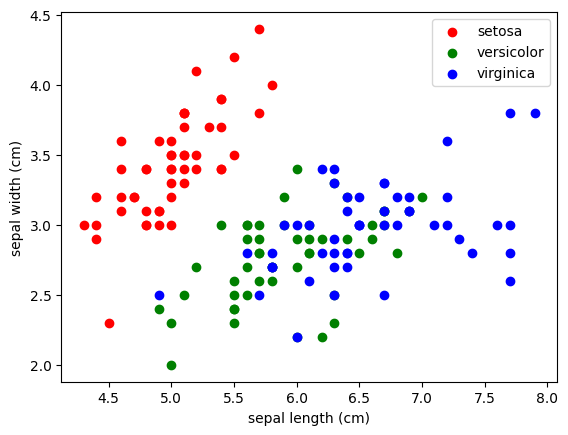

In [32]:
## SELECT FEATURES TO PLOT
#change these two values to plot different features, remembering the numbering:
# 0 : sepal length (cm)
# 1 : sepal width (cm)
# 2 : petal length (cm)
# 3 : petal width (cm)
feature_x = 0
feature_y = 1

#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

This time, we are going to use all three classes as they are.

The problem is that our target array `iris.target` is a numeric array (e.g. [1 0 0 2 1 1 0 ...]).
However teose numbers (0, 1, and 2) do not represent real values. In other words, "virginica" is not twice "versicolor". Numbers here are used as labels, not as quantities.

As a matter of fact, to properly train a model the structure of the target array must be changed to [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). In simple terms, it needs to become a table with one row per sample (150 in total) and one column per class (three in total). Something like:

| Setosa | Versicolor | Virginica |
|------|------|------|
|   0  |   1  |   0  |
|   1  |   0  |   0  |
|   1  |   0  |   0  |
|   0  |   0  |   1  |

As you can see the first sample is Versicolor, the second and third are Setosa, the last one is Virginica. Note that there is only a single "one" per row.

We need to do a little **preprocessing**.

## Data preprocessing

As said, we need to convert a numeric vector to a one-hot encoding (OHE) representation.
Luckily, it's easy to pass to one-hot encode using the keras function [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function):

To make the problem a little more challenging (and interesting) we decide to **drop half of the features**, **using only the first two** columns.

In [33]:
#the "utils" subpackage is very useful, take a look to it when you have time
from tensorflow.keras.utils import to_categorical

#converting to categorical
target_multi_cat = tf.keras.utils.to_categorical(target)

#since everything else is a Pandas dataframe, let's stick to the format
#for consistency
target_multi_cat = pd.DataFrame(target_multi_cat)

#let's take a look
print(target_multi_cat)

       0    1    2
0    1.0  0.0  0.0
1    1.0  0.0  0.0
2    1.0  0.0  0.0
3    1.0  0.0  0.0
4    1.0  0.0  0.0
..   ...  ...  ...
145  0.0  0.0  1.0
146  0.0  0.0  1.0
147  0.0  0.0  1.0
148  0.0  0.0  1.0
149  0.0  0.0  1.0

[150 rows x 3 columns]


We get the first two features, to make the example comparable with the previous notebook on binary classification

In [34]:
features = iris.data.iloc[:,0:2] ## we are selecting the first two features / columns

## Training and validation sets

Each time there is some kind of "learning" involved we need to split our data. A subset will be used for training, and a subset will be used for validation.

In our current dataset the samples are sorted by class: the first 100 are "non-virginica" and the remaining 50 are "virginica".
We want to keep this 2:1 proportion (roughly) the same in both train and validation set.

Obviously (given the ordered data), taking the first $80\%$ (120 samples) of the data as training and the rest (30 samples) as validation would be a bad choice ... (only 'virginica' samples in the validation set, 4:1 class proportion in the training set).   

Simple random sampling would also not be a good solution, since the 2:1 proportion will not be maintained.

Therefore we are going to use what is called a [stratified approach](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/) using a [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) object from `scikit-learn`:


In [35]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

test_pct = 0.2

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
#random_state is used to control class balance between training and test sets (None to switch to random behavior)
sss = StratifiedShuffleSplit(n_splits=1, test_size= test_pct, random_state=0)

for train_index, val_index in sss.split(features, target_multi_cat):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target_multi_cat.iloc[train_index, :]
    target_val     = target_multi_cat.iloc[val_index, :]

We now perform a little sanity check to see whether the split worked as expected:

In [36]:
#shapes
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

#number of classes per split
print('\nClasses in train set:')
print(target_train.sum())
print('\nClasses in validation set:')
print(target_val.sum())

(120, 2)
(30, 2)
(120, 3)
(30, 3)

Classes in train set:
0    40.0
1    40.0
2    40.0
dtype: float32

Classes in validation set:
0    10.0
1    10.0
2    10.0
dtype: float32


We have now a balanced dataset, with 40 instances for each class in the training set and 10 in the validation set. Job done!

### Feature normalization

We calculate the average and standard deviation on the training data: then we use these values to normalize the features both in the training and in the test datasets <!-- (!! **IMPORTANT** !!) -->

In [37]:
#calculating features averages and std devs
avg = features_train.mean()
std = features_train.std()

#standardizing the data (mean 0, std 1)
features_train = (features_train - avg)/std
features_val = (features_val - avg)/std

## Build the neural network model

[TODO]

We want to use a neural network model for softmax regression.
As for the rest of the book, in this notenook we are using the `Python`-based `Keras`/`Tensorflow` framework.

Our neural network will be very minimal, as illustrated in the sketch at the beginning of this notebook: it will comprise only one layer (softmax layer) with three units (since this is a three-class problem) that will perform both 1) the linear combination of weighted input variables + bias term; and 2) softmax activation of the result from step 1, to produce the probabilities for a sample of belonging to each class.

We are now ready to build the NN (neural network) model!

- model set-up
- model architecture and compiling

### Model set-up

We first need to define some hyperparameters:

1. number of classes (units in the softmax layer)
2. activation function (`softmax`, this is a multiclass classification problem)
3. optimizer (the algorithm that carries out forward and backpropagation to solve the model)
4. the loss function (`categorical cross-entropy`, again this is multiclass classification!)

In [38]:
num_classes = 3
input_shape = features_train.shape[1]
activation_function = 'softmax'
optimising_method = 'adam'
loss_function = 'categorical_crossentropy'
num_epochs = 200

### Model architecture

This is a one-layer one-unit neural network model.
The neural network is fully connected, meaning that the unit receives in input all features.

In [39]:
from keras.models import Sequential
from keras.layers import Dense

# 3-class softmax regression in Keras
model_multi = Sequential()
model_multi.add(Dense(units = num_classes, activation=activation_function, input_dim=input_shape))

#compile the model specifying the new multiclass loss
model_multi.compile(optimizer=optimising_method, loss=loss_function)

With the `.summary()` method we can take a look "under the hood":

In [40]:
print(model_multi.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


We now have to train 9 parameters: 3 coefficients (W1, W2 B) times three units/nodes.
The output is a vector of length three (three probabilities normalised to sum to one). Excellent!

## Training the neural network model

Now that the model has been built and compiled, we are ready to train it on the data.
Training is an iterative process that cycles many times through what are called `epochs`. Remeber: one epoch is one cycle of forward and backward propagation.

We'll go directly to the total number of epochs:

In [41]:
history_multi = model_multi.fit(features_train, target_train, epochs=num_epochs, validation_data=(features_val, target_val), verbose=0)

We asked for ten epochs and the network did just that. At each iteration the network is trying really hard to minimize the ["loss"](https://keras.io/api/losses/). The specifics are defined by our choice of loss function (we selected `binary_crossentropy`). The basic idea is that the smaller the loss the better the fit.

Note that the network minimizes the loss on the training set and does not use the validation set during the learning process. It can however measure the loss on the validation set to give us an idea on how well it can generalize on new data.

It's handy at this point to define a function that takes in the `history` object returned by `.fit()` and plots it:

In [42]:
#function to take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

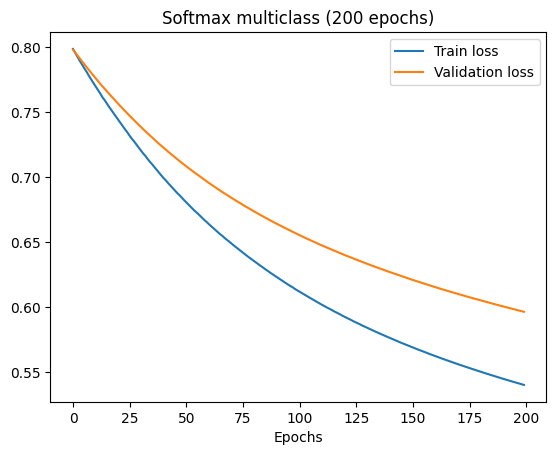

In [43]:
plot_loss_history(history_multi, 'Softmax multiclass ({} epochs)'.format(num_epochs))

This looks promising. There's the clear same pattern we saw with logistic regression, with a strong improvement in the first hundred epochs (and then things become slow...)

## Model evaluation

As said, a model is useful to predict new, unknown data, and it is therefore critical to evaluate it's performance.

Again, we look at the following:

- decision boundary
- confusion matrix / accuracy
- Cohen's kappa

### Decision Boundary

We now need to extend the code for inspecting the decision boundary beyond the case of two classes.
Unfortunately, the `plot_decision_regions` function from [mlxtend](http://rasbt.github.io/mlxtend/) module does not support one-hot encoded multiclasses natively.
Luckily [there's a quick workaround](https://www.machinecurve.com/index.php/2019/10/17/how-to-use-categorical-multiclass-hinge-with-keras/#visualizing-the-decision-boundary), but if you get lost in the code don't worry and just look at the plot :)

In [46]:
#we define a class to take the Keras model and convert its predictions
#from "one probability per iris type" to "just the iris type with the highest probability"
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)

#we wrap our trained model, instantiating a new object
keras_model_no_ohe = Onehot2Int(model_multi)

9600/9600 [==============================] - 13s 1ms/step


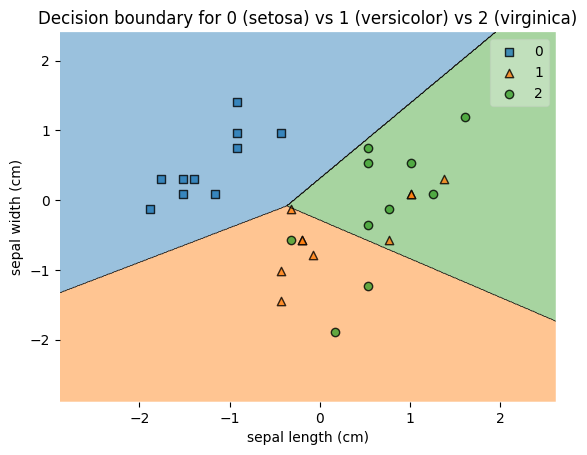

In [45]:
#and we can now plot the decision boundary safely (we still need to convert
#the target one-hot-encoded matrix to int, though)
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(features_val.to_numpy(), np.argmax(target_val.to_numpy(), axis=1),
                      clf=keras_model_no_ohe) ## clf = classifier object
plt.title('Decision boundary for 0 (setosa) vs 1 (versicolor) vs 2 (virginica)')
plt.xlabel(iris.feature_names[feature_x])
plt.ylabel(iris.feature_names[feature_y])
plt.show()

The colored areas (orange, blue, green) represent the behaviour of the trained model; the blue squares, orange triangles and green circles are the actual samples in the validation set.

The **decision boundaries are linear**, as expected by softmax regression. This means that all samples in the orange area will be classified as 1 (versicolor), all points in the blue area as 0 (setosa), and alls samples in the green area as 2 (virginica).

Note that: i) it is very easy to classify correctly the *setosa* samples; ii) contrariwise, there are relatively many virginica samples in the yellow area (versicolor) and versicolor samples in the green area (virginica). The classes "1" and "2" are more difficult to distinguish based on the input features.

Also note that, roughly speaking, the softmax regressor assigned approximately the same area to all three classes. This is a direct consequence of having a balanced dataset: each class comprises one thirds of the samples.

### Confusion matrix / accuracy

To construct the confusion matrix and to calculate the accuracy of the trained neural network model for softmax regression, we first need to get the predictions made on the validation set.
Luckily, it's very easy to apply a trained model to new data (the validation set) via the [predict() method](https://keras.io/api/models/model_training_apis/#predict-method).

We can thus get our prediction for the iris flowers (see below): note that we have now a vector of probabilities (three probabilities) for each sample in the validation set.
Each sample will be classified based on the largest probability value (e.g. the first sample will be classified as "2", the secinda sample as "1" etc.).

In [50]:
predictions = model_multi.predict(features_val)
print(predictions)

1/1 [==============================] - 0s 213ms/step
[[0.3813779  0.15019165 0.46843046]
 [0.12852152 0.50829315 0.36318538]
 [0.16585253 0.19637688 0.6377706 ]
 [0.6833229  0.17636532 0.14031176]
 [0.05934427 0.2688928  0.67176294]
 [0.07539614 0.64333445 0.2812694 ]
 [0.8480229  0.08401125 0.06796594]
 [0.08027077 0.34759253 0.57213664]
 [0.07568215 0.4171195  0.5071983 ]
 [0.03042124 0.7458569  0.2237218 ]
 [0.8001371  0.05908729 0.1407756 ]
 [0.2971093  0.3543589  0.3485318 ]
 [0.03637269 0.45256302 0.5110643 ]
 [0.8464854  0.05973954 0.09377512]
 [0.07361009 0.5694975  0.35689238]
 [0.88647974 0.06594127 0.04757903]
 [0.7862926  0.14562729 0.06808015]
 [0.08345341 0.28392458 0.63262206]
 [0.07175226 0.22134067 0.7069071 ]
 [0.01378409 0.6272294  0.35898647]
 [0.00541402 0.7807152  0.21387087]
 [0.9483035  0.01374053 0.03795585]
 [0.78097093 0.1311475  0.08788152]
 [0.8249017  0.09430889 0.08078939]
 [0.14837806 0.5084959  0.3431261 ]
 [0.0834534  0.28392455 0.632622  ]
 [0.1285215

With the predictions and the target labels in the validation set we can construct the **confusion matrix** and get a detailed overview of the model performance.  

In [52]:
from sklearn.metrics import confusion_matrix

predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape(len(predicted_classes),1)

target_classes = iris.target.iloc[val_index].to_numpy()

### for later use ###
predicted_classes_logistic = predicted_classes
target_classes_logistic = target_classes
### --- ###

con_mat_df = confusion_matrix(target_classes, predicted_classes, labels = [0,1,2])
print("\nConfusion matrix:")
print(con_mat_df)


Confusion matrix:
[[10  0  0]
 [ 0  6  4]
 [ 0  3  7]]


We see that all *setosa* samples in the validation set have been classified correctly (we knew this already from the plot of the decision boundary). The number of correct predictions was 6 (out of 10) for *versicolor* flowers, and 7 (out of 10) for *virginica*.

It can be useful to visualize the confusion matrix in a plot:

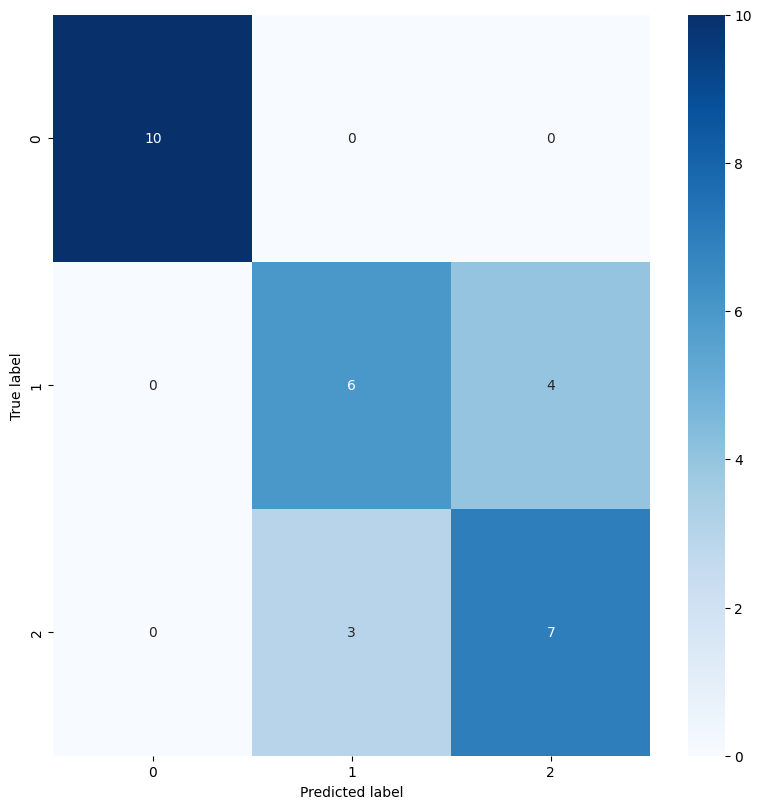

In [49]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Cohen's kappa